## **Overview** ##

The script performs survival analysis using:

- Kaplan-Meier Estimator (non-parametric method).
- Cox Proportional Hazards Model (semi-parametric regression model).
- Handling Censored Data (adjusting for missing survival times).

### **1. Data Preprocessing and Cleaning** ### 

- df.head() shows the first few rows to get an idea of the data.
- df.nunique() checks how many unique values each column has.

As for why we removed the following columns, if a column has only one unique value, it doesn’t provide useful information. Removing such columns reduces redundancy and improves model performance. This is caused by identical rows or constant columns. Similarly, if two rows are identical it causes issues in matrix inversion. Which will be happening in the upcoming steps.


- df = df.loc[:, df.nunique() > 1]  # Drop columns with only 1 unique value
- df.drop(columns=['age_s'], inplace=True)  # Drops 'age_s'

Then we visualize correlations between numerical variables using **Correlation Heatmap** to help detect redudant features. Highly correlated variables can cause multicollinearity in regression models.

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
--------------------------------
Number of unique values per column:
id            89
period        20
treatment      2
x1             2
x2           725
x3             2
x4            89
age           60
age_s         60
outcome        2
censored       2
eligible       2
dtype: int64


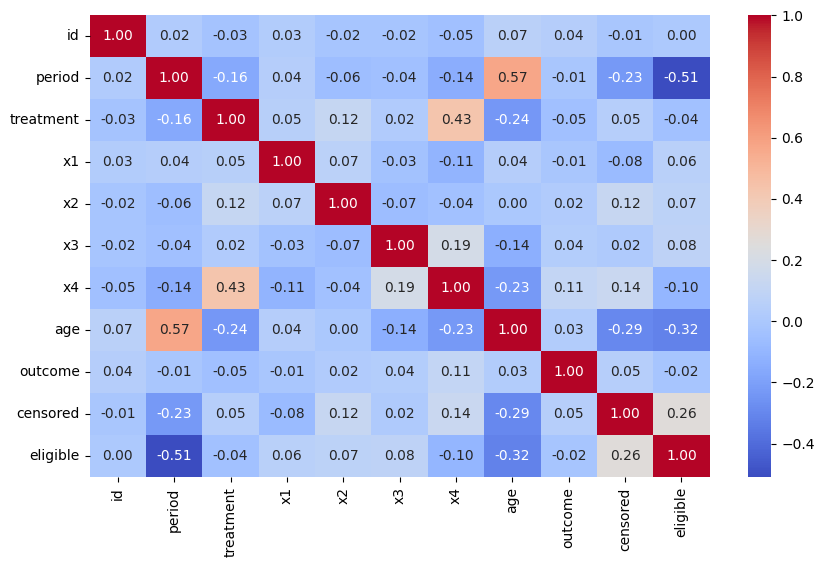

In [4]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import add_covariate_to_timeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

df = pd.read_csv('data_censored.csv')

print(df.head())
print("--------------------------------")
print("Number of unique values per column:")
print(df.nunique())

df = df.loc[:, df.nunique() > 1]

df.drop(columns=['age_s'], inplace=True)

corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### **2. Checking for Multicollinearity (Variance Inflation Factor - VIF)** ###

We use VIF to measure how much a variable is explained by other variables.

- High VIF (greater than 10) means a variable is highly correlated with others, which should be removed.
- Low VIF (Less than 10) is acceptable.

So if column "age" as a high VIF we remove it, this reduces multicollinearity, improving model reliability.

In [5]:
X = df.drop(columns=['id', 'outcome'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     Feature       VIF
0     period  4.543482
1  treatment  2.135012
2         x1  1.738900
3         x2  1.069515
4         x3  1.932115
5         x4  1.498206
6        age  7.435893
7   censored  1.197863
8   eligible  1.845369


### **3. Modeling Censoring Probability (Handling Missing Survival Data)** ###

Here we used Logistic Regression (Logit Model):

- To predict whether an observation is censored (missing survival time) using predictor variables (x1, x2).
- Censoring occurs when we don’t observe the full survival time (e.g., patient drops out).

Then, Inverse Probability Weighting (IPW):

- Adjusting for censoring bias.
- Observations with higher censoring probability are weighted lower.

In [6]:
censor_model = sm.Logit(df['censored'], df[['x1', 'x2']])
censor_result = censor_model.fit()
df['censor_prob'] = censor_result.predict(df[['x1', 'x2']])

df['censor_weight'] = 1 / df['censor_prob']

Optimization terminated successfully.
         Current function value: 0.474102
         Iterations 7


### **4. Cox Proportional Hazards Model (Survival Analysis)** ###

CoxPH model estimates how covariates affect survival time.

Key Parameters:

- duration_col='period' → Time until the event occurs.
- event_col='outcome' → Whether the event (e.g., death) happened (1 = Yes, 0 = No).
- weights_col='censor_weight' → Adjusts for censoring.

In [7]:
cph = CoxPHFitter()
cph.fit(df, duration_col='period', event_col='outcome', weights_col='censor_weight')
cph.print_summary()

c:\Users\martb\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(
c:\Users\martb\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<lifelines.CoxPHFitter: fitted with 7909.48 total observations, 7839 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
              weights col = 'censor_weight'
      baseline estimation = breslow
   number of observations = 7909.48
number of events observed = 70.4791
   partial log-likelihood = -389.89
         time fit was run = 2025-03-09 07:12:39 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
id            0.03      1.03      0.01            0.02            0.04                1.02                1.04
treatment    -2.60      0.07      0.38           -3.34           -1.86                0.04                0.16
x1           -7.38      0.00      1.83          -10.97           -3.79                0.00                0.02
x2            2.24      9.35      0.39            1.48            3.00                4.38               20.00
x3            1.20      3.33      0.37            0.48            1.93                1.62                6.86
x4            1.86      6.45      0.19            1.49            2.24                4.45                9.35
age           0.04      1.04      0.02            0.00            0.07                1.00                1.07
censored      5.23    186.79      0.44            4.37            6.09               78.67              443.51
eligible      0.16      1.17      0.60           -1.02            1.34                0.36                3.82
censor_prob -15.15      0.00      3.95          -22.90           -7.41                0.00                0.00

             cmp to     z      p  -log2(p)
covariate                                 
id             0.00  4.67 <0.005     18.37
treatment      0.00 -6.85 <0.005     36.99
x1             0.00 -4.03 <0.005     14.14
x2             0.00  5.77 <0.005     26.90
x3             0.00  3.26 <0.005      9.83
x4             0.00  9.83 <0.005     73.41
age            0.00  2.27   0.02      5.44
censored       0.00 11.85 <0.005    105.26
eligible       0.00  0.26   0.79      0.33
censor_prob    0.00 -3.83 <0.005     12.96
---
Concordance = 0.88
Partial AIC = 799.77
log-likelihood ratio test = 380.77 on 10 df
-log2(p) of ll-ratio test = 248.93

### **5. Kaplan-Meier Survival Curve** ###

Kaplan-Meier Estimator calculates survival probability at different times.

Interpreting the plot:

- Higher curve = higher survival probability.
- Steeper drops = high event rates (e.g., high death rates).

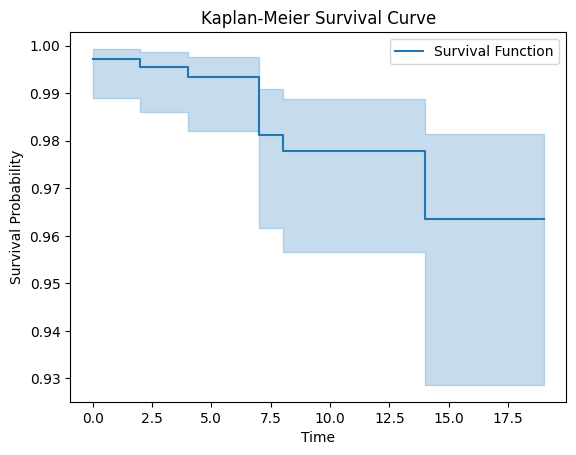

In [8]:
kmf = KaplanMeierFitter()

kmf.fit(durations=df['period'], event_observed=df['outcome'], label='Survival Function')

kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

### **6. Compares survival probabilities between two groups (Control vs. Treatment).** ####

Interpretation:

- Above zero → Treatment has better survival.
- Below zero → Control group survives better.

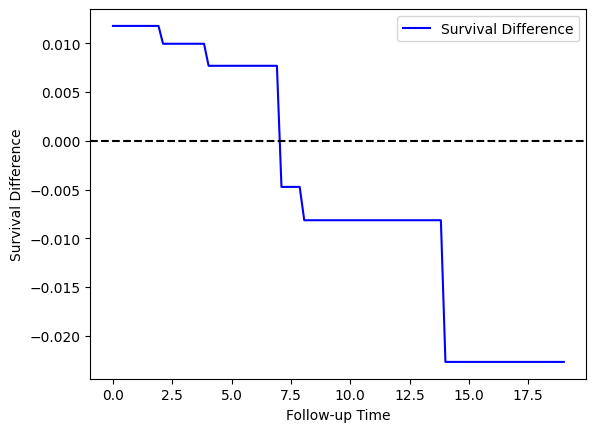

In [9]:
kmf_control = KaplanMeierFitter()
kmf_treatment = KaplanMeierFitter()

kmf_treatment.fit(df[df['censored'] == 0]['period'], event_observed=df[df['censored'] == 0]['outcome'])
kmf_control.fit(df[df['eligible'] == 1]['period'], event_observed=df[df['eligible'] == 1]['outcome'])

time_points = np.linspace(0, df['period'].max(), 100) 
control_survival = kmf_control.predict(time_points)
treatment_survival = kmf_treatment.predict(time_points)

survival_diff = treatment_survival - control_survival

plt.plot(time_points, survival_diff, label="Survival Difference", color="blue")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.axhline(y=0, color="black", linestyle="--")
plt.legend()
plt.show()

### **Insights** ###

1. Data Cleaning & Feature Selection

- Dropping low-variance columns ensures that only informative variables are retained.
- VIF analysis removes highly collinear variables, improving model stability.

2. Censoring Adjustments

- The Logit model estimates censoring probability, reducing bias.
- Inverse probability weighting (IPW) accounts for censoring effects.

3. Survival Analysis

- Kaplan-Meier curves visualize overall survival probabilities.
- The Cox model provides hazard ratios, showing which factors influence survival.
    - HR > 1 → Increased risk (smoking increases death risk).
    - HR < 1 → Protective effect (exercise reduces risk).

4. Group Comparisons

- Kaplan-Meier stratification by groups (e.g., treatment vs. control) reveals differences in survival.
- The survival difference curve provides insights into treatment effectiveness.